# Tutorial: Bayesian Convolutional Neural Networks for Jet Classification - SOLUTION

## Introduction

In this tutorial, you will learn to implement and train Bayesian Convolutional Neural Networks (Bayesian CNNs) for jet classification in particle physics. Bayesian neural networks provide uncertainty quantification by treating network weights as probability distributions rather than fixed values.

### Learning Objectives
- Understand the principles of Bayesian deep learning
- Implement Bayesian convolutional layers using the reparameterization trick
- Train a Bayesian CNN for binary classification of particle jets
- Quantify predictive uncertainty using Monte Carlo sampling
- Evaluate model performance with ROC curves and uncertainty analysis

### Background
Particle jets are collimated sprays of particles produced in high-energy collisions. Distinguishing between signal jets (e.g., from top quark decay) and background jets is crucial for many physics analyses. Bayesian neural networks not only provide classification predictions but also quantify uncertainty in those predictions, which is valuable for physics applications where understanding model confidence is essential.

### Tutorial Outline

1. **Data Loading and Preprocessing**
   - Load jet constituent data
   - Convert particle constituents to image representation
   - Preprocess jet images (centering, rotation, normalization)

2. **Bayesian Neural Network Components**
   - Implement Bayesian convolutional layers using reparameterization trick
   - Understand KL divergence regularization

3. **Model Architecture**
   - Design Bayesian CNN for jet classification
   - Combine Bayesian and standard layers

4. **Training and Evaluation**
   - Implement Bayesian loss function (negative log-likelihood + KL divergence)
   - Train the model with proper regularization
   - Evaluate classification performance

5. **Uncertainty Quantification**
   - Use Monte Carlo sampling for uncertainty estimation
   - Analyze prediction uncertainty patterns
   - Visualize uncertainty vs prediction confidence

## 1. Data Loading and Setup

### Load Required Libraries

In [6]:
import os
import sys
import random
import time
import math
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init, Module
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt

Set the correct patht to the get_data.py script

In [7]:
#Download the dataset
!pip install wget
!python3 data/get_data.py 2 data

Trying to download dataset 2 ('top tagging', used in tutorials [5, 6, 7, 8, 9]) from https://www.thphys.uni-heidelberg.de/~plehn/data/toptagging-short.zip to toptagging-short.zip
100%|█████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]
Successfully extracted files from toptagging-short.zip


### Load Dataset

Load the data using the correct path you set previously for the script

In [8]:
X_train = np.load( "data/toptagging-short/x_train_short.npy")
y_train = np.load( "data/toptagging-short/y_train_short.npy")
X_test = np.load( "data/toptagging-short/x_test_short.npy")
y_test = np.load( "data/toptagging-short/y_test_short.npy")
X_val = np.load( "data/toptagging-short/x_val_short.npy")
y_val = np.load( "data/toptagging-short/y_val_short.npy")

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (30000, 200, 4), (30000,)
Validation set: (30000, 200, 4), (30000,)
Test set: (30000, 200, 4), (30000,)


## 2. Data Preprocessing

### Image Conversion Functions

We need to convert particle constituents (4-momentum vectors) into 2D images in the $\eta$-$\phi$ plane.

In [9]:
# Grid settings for image creation
xpixels = np.arange(-2.6, 2.6, 0.029)  # eta range
ypixels = np.arange(-np.pi, np.pi, 0.035)  # phi range

def eta(pT, pz):
    """Calculate pseudorapidity from transverse momentum and z-momentum"""
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = -np.log(np.tan(theta/2))
    return etas

def phi(px, py):
    """Calculate azimuthal angle from x and y momentum components"""
    phis = np.arctan2(py, px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

def mass(E, px, py, pz):
    """Calculate invariant mass from 4-momentum"""
    return np.sqrt(np.maximum(0., E**2 - px**2 - py**2 - pz**2))

def img_mom(x, y, weights, x_power, y_power):
    """Calculate image moments for centering and rotation"""
    return ((x**x_power) * (y**y_power) * weights).sum()

def orig_image(etas, phis, es):
    """Create 2D histogram image from eta, phi coordinates and energies"""
    z = np.zeros((etas.shape[0], len(xpixels), len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | 
                (phis < ypixels[0]) | (phis > ypixels[-1]))
    
    xcoords = np.argmin(np.abs(etas[:, None, :] - xpixels[None, :, None]), axis=1)
    ycoords = np.argmin(np.abs(phis[:, None, :] - ypixels[None, :, None]), axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:, None], etas.shape[1], axis=1)
    
    z[ncoords[in_grid], ycoords[in_grid], xcoords[in_grid]] = es[in_grid]
    return z

In [10]:
def preprocessing(x, y, weights, rotate=True, flip=True):
    """Preprocess jet image: center, rotate, and flip for standardization"""
    # Center the image
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1) / weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    if rotate:
        # Calculate covariance matrix for rotation
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Find principal axis
        evals, evecs = np.linalg.eig(cov)
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]

        # Rotate so principal axis is vertical
        theta = np.arctan2(e_1[0], e_1[1])
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], 
                             [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x, y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flip for consistency
    if flip:
        if weights[x_rot < 0.].sum() < weights[x_rot > 0.].sum():
            x_rot = -x_rot
        if weights[y_rot < 0.].sum() > weights[y_rot > 0.].sum():
            y_rot = -y_rot
            
    return x_rot, y_rot

In [11]:
def constit_to_img(jets, n_constit, norm, rotate, flip):
    """Convert jet constituents to preprocessed images"""
    print("Crop constituents")
    jets = jets[:, 0:n_constit, :]
    
    print("Calculating kinematic variables")
    E = jets[:, :, 0]
    pxs = jets[:, :, 1]
    pys = jets[:, :, 2]
    pzs = jets[:, :, 3]
    pT = np.sqrt(pxs**2 + pys**2)
    
    etas = eta(pT, pzs)
    phis = phi(pxs, pys)
    
    # Pre-shift phis to handle periodicity
    print("Pre-shifting phis")
    phis = (phis.T - phis[:, 0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    weights = pT  # Use pT as weights
    
    print("Preprocessing")
    for i in range(np.shape(etas)[0]):
        etas[i, :], phis[i, :] = preprocessing(etas[i, :], phis[i, :], 
                                              weights[i, :], rotate, flip)
    
    print("Creating images")
    z_ori = orig_image(etas, phis, weights)
        
    print("Cropping and normalizing")
    n_crop = 40
    z_new = np.zeros((z_ori.shape[0], n_crop, n_crop))
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i, :, :].shape
        z_new[i, :, :] = z_ori[i, 
                               int(Npix[0]/2 - n_crop/2):int(Npix[0]/2 + n_crop/2), 
                               int(Npix[1]/2 - n_crop/2):int(Npix[1]/2 + n_crop/2)]
        if norm:
            z_sum = z_new[i, :, :].sum()
            if z_sum != 0.:
                z_new[i, :, :] = z_new[i, :, :] / z_sum
    
    print("Reshaping")
    z_out = z_new.reshape((z_new.shape[0], -1))
    
    return z_out

### Convert Constituents to Images

In [12]:
# Convert constituent data to images
z_train = constit_to_img(X_train, 50, True, True, True)
z_test = constit_to_img(X_test, 50, True, True, True)
z_val = constit_to_img(X_val, 50, True, True, True)

Crop constituents
Calculating kinematic variables
Pre-shifting phis
Preprocessing
Creating images
Cropping and normalizing
Reshaping
Crop constituents
Calculating kinematic variables
Pre-shifting phis
Preprocessing
Creating images
Cropping and normalizing
Reshaping
Crop constituents
Calculating kinematic variables
Pre-shifting phis
Preprocessing
Creating images
Cropping and normalizing
Reshaping


### Visualize Average Jet Images

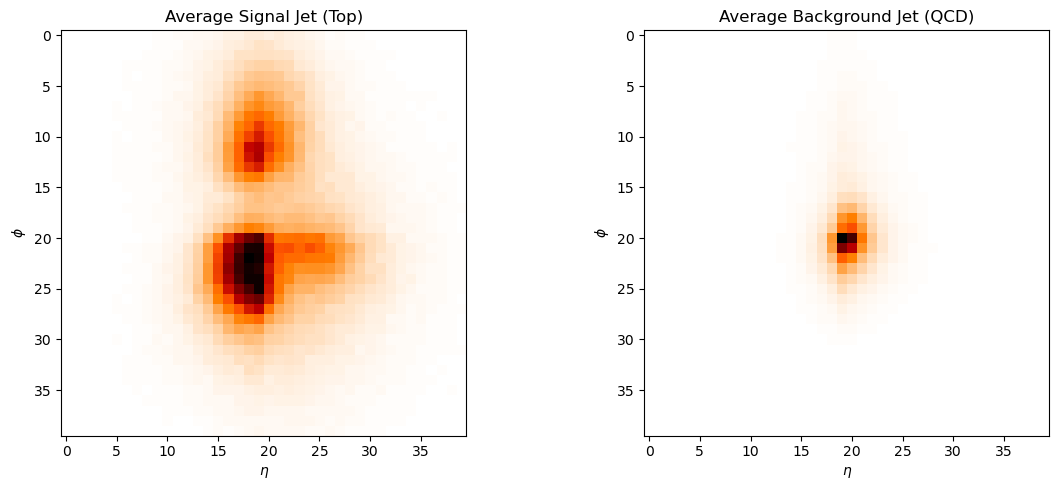

In [13]:
# Separate signal and background for visualization
sig = z_train[np.where(y_train == 1)]
bkg = z_train[np.where(y_train == 0)]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot average signal jet
axs[0].imshow(sig.mean(0).reshape((40, 40)), cmap="gist_heat_r")
axs[0].set_title("Average Signal Jet (Top)")
axs[0].set_xlabel("$\\eta$")
axs[0].set_ylabel("$\\phi$")

# Plot average background jet
axs[1].imshow(bkg.mean(0).reshape((40, 40)), cmap="gist_heat_r")
axs[1].set_title("Average Background Jet (QCD)")
axs[1].set_xlabel("$\\eta$")
axs[1].set_ylabel("$\\phi$")

plt.tight_layout()
plt.show()

## 3. Dataset and DataLoader Setup

In [14]:
class CNNData(Dataset):
    """Custom dataset for CNN training"""
    
    def __init__(self, imgs, labels):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [15]:
# Reshape for CNN input and convert to tensors
z_train = torch.Tensor(z_train.reshape(-1, 1, 40, 40).astype('float32'))
z_test = torch.Tensor(z_test.reshape(-1, 1, 40, 40).astype('float32'))
z_val = torch.Tensor(z_val.reshape(-1, 1, 40, 40).astype('float32'))

y_train = torch.Tensor(y_train).unsqueeze(-1)
y_test = torch.Tensor(y_test).unsqueeze(-1)
y_val = torch.Tensor(y_val).unsqueeze(-1)

# Create datasets and dataloaders
train_dataset = CNNData(z_train, y_train.float())
test_dataset = CNNData(z_test, y_test.float())
val_dataset = CNNData(z_val, y_val.float())

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

print(f"Data shapes - Train: {z_train.shape}, Val: {z_val.shape}, Test: {z_test.shape}")

Data shapes - Train: torch.Size([30000, 1, 40, 40]), Val: torch.Size([30000, 1, 40, 40]), Test: torch.Size([30000, 1, 40, 40])


## 4. Bayesian Neural Network Components

### Variational Bayesian Linear Layer

The core of Bayesian neural networks is treating weights as distributions rather than fixed values. We use the reparameterization trick to enable backpropagation through stochastic nodes.

In [16]:
class VBLinear(Module):
    """Variational Bayesian Linear Layer
    
    Implements a linear layer where weights are treated as distributions.
    Uses reparameterization trick: w = μ + σ * ε, where ε ~ N(0,1)
    """
    
    def __init__(self, in_features, out_features):
        super(VBLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.resample = True
        
        # Parameters for weight distribution: w ~ N(μ, σ²)
        self.bias = Parameter(Tensor(out_features))
        self.mu_w = Parameter(Tensor(out_features, in_features))  # Weight means
        self.logsig2_w = Parameter(Tensor(out_features, in_features))  # Log weight variances
        
        # Random noise for reparameterization
        self.random = torch.randn_like(self.logsig2_w)
        self.reset_parameters()
        
    def forward(self, input):
        if self.resample:
            self.random = torch.randn_like(self.logsig2_w)
        
        # Reparameterization trick: w = μ + σ * ε
        s2_w = self.logsig2_w.exp()  # Convert log variance to variance
        weight = self.mu_w + s2_w.sqrt() * self.random
        
        return F.linear(input, weight, self.bias)
    
    def reset_parameters(self):
        """Initialize parameters"""
        stdv = 1. / np.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)  # Start with small variance
        self.bias.data.zero_()
        
    def KL(self, loguniform=False):
        """Calculate KL divergence from prior N(0,1)"""
        return 0.5 * (self.mu_w.pow(2) + self.logsig2_w.exp() - self.logsig2_w - 1).sum()

### Bayesian Convolutional Layer

Similar to the linear layer, but for convolutional operations. This is more complex as we need to handle multiple dimensions.

In [17]:
from torch.nn.common_types import _size_2_t
from typing import Optional, Union

def KL_DIV(mu_q, sig_q, mu_p, sig_p):
    """Calculate KL divergence between two Gaussians"""
    kl = 0.5 * (2 * torch.log(sig_p / sig_q) - 1 + 
                (sig_q / sig_p).pow(2) + ((mu_p - mu_q) / sig_p).pow(2)).sum()
    return kl

class BBBConv2d(Module):
    """Bayes by Backprop Convolutional Layer
    
    Implements a convolutional layer with Bayesian weights.
    Based on the paper "Weight Uncertainty in Neural Networks" by Blundell et al.
    """
    
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, bias=True, priors=None):
        super(BBBConv2d, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = 1
        self.use_bias = bias
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Prior and posterior parameters
        if priors is None:
            priors = {
                'prior_mu': 0,
                'prior_sigma': 0.1,
                'posterior_mu_initial': (0, 0.1),
                'posterior_rho_initial': (-3, 0.1),
            }
        self.prior_mu = priors['prior_mu']
        self.prior_sigma = priors['prior_sigma']
        self.posterior_mu_initial = priors['posterior_mu_initial']
        self.posterior_rho_initial = priors['posterior_rho_initial']

        # Weight parameters: μ and ρ (where σ = log(1 + exp(ρ)))
        self.W_mu = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), 
                                        device=self.device))
        self.W_rho = Parameter(torch.empty((out_channels, in_channels, *self.kernel_size), 
                                         device=self.device))

        if self.use_bias:
            self.bias_mu = Parameter(torch.empty((out_channels), device=self.device))
            self.bias_rho = Parameter(torch.empty((out_channels), device=self.device))
        else:
            self.register_parameter('bias_mu', None)
            self.register_parameter('bias_rho', None)

        self.reset_parameters()

    def reset_parameters(self):
        """Initialize parameters"""
        self.W_mu.data.normal_(*self.posterior_mu_initial)
        self.W_rho.data.normal_(*self.posterior_rho_initial)

        if self.use_bias:
            self.bias_mu.data.normal_(*self.posterior_mu_initial)
            self.bias_rho.data.normal_(*self.posterior_rho_initial)

    def forward(self, input, sample=True):
        """Forward pass with weight sampling"""
        if self.training or sample:
            # Sample weights: w = μ + σ * ε
            W_eps = torch.empty(self.W_mu.size()).normal_(0, 1).to(self.device)
            self.W_sigma = torch.log1p(torch.exp(self.W_rho))  # σ = log(1 + exp(ρ))
            weight = self.W_mu + W_eps * self.W_sigma

            if self.use_bias:
                bias_eps = torch.empty(self.bias_mu.size()).normal_(0, 1).to(self.device)
                self.bias_sigma = torch.log1p(torch.exp(self.bias_rho))
                bias = self.bias_mu + bias_eps * self.bias_sigma
            else:
                bias = None
        else:
            # Use mean weights for deterministic inference
            weight = self.W_mu
            bias = self.bias_mu if self.use_bias else None

        return F.conv2d(input, weight, bias, self.stride, 
                       self.padding, self.dilation, self.groups)

    def KL(self):
        """Calculate KL divergence from prior"""
        kl = KL_DIV(self.prior_mu, self.prior_sigma, self.W_mu, self.W_sigma)
        if self.use_bias:
            kl += KL_DIV(self.prior_mu, self.prior_sigma, self.bias_mu, self.bias_sigma)
        return kl

## 5. Bayesian CNN Architecture

In [ ]:
class BayesConvNet2D(nn.Module):
    """Bayesian Convolutional Neural Network for Jet Classification
    
    Architecture:
    - Bayesian Conv2d + ReLU + MaxPool
    - Bayesian Conv2d + MaxPool
    - Flatten
    - Bayesian Linear + Sigmoid
    """
    
    def __init__(self, training_size, in_ch=1, ch=4, out_dim=1, img_sz=40):
        super().__init__()
        self.training_size = training_size
        
        # Track Bayesian layers for KL calculation
        self.vb_layers = []
        self.all_layers = []
        
        # First Bayesian convolutional block
        self.conv1 = BBBConv2d(in_ch, ch, kernel_size=5, bias=True, stride=1, padding=2)
        self.vb_layers.append(self.conv1)
        self.all_layers.append(self.conv1)
        self.all_layers.append(nn.ReLU())
        
        # First pooling layer
        self.max1 = nn.MaxPool2d(kernel_size=2)
        self.all_layers.append(self.max1)
        self.all_layers.append(nn.ReLU())
        
        # Second Bayesian convolutional block
        self.conv2 = BBBConv2d(ch, 1, kernel_size=5, bias=True, stride=1, padding=2)
        self.vb_layers.append(self.conv2)
        self.all_layers.append(self.conv2)
        
        # Second pooling layer
        self.max2 = nn.MaxPool2d(kernel_size=2)
        self.all_layers.append(self.max2)
        
        # Flatten for fully connected layer
        self.flatten = nn.Flatten()
        self.all_layers.append(self.flatten)
        
        # Bayesian fully connected output layer
        self.out = VBLinear(int(img_sz * img_sz / 16), out_dim)
        self.vb_layers.append(self.out)
        self.all_layers.append(self.out)
        
        # Sigmoid activation for binary classification
        self.all_layers.append(nn.Sigmoid())
    
    def forward(self, x):
        """Forward pass through the network"""
        self.net = nn.Sequential(*self.all_layers)
        return self.net(x)
    
    def KL(self):
        """Calculate total KL divergence from all Bayesian layers"""
        kl = 0
        for vb_layer in self.vb_layers:
            kl += vb_layer.KL()
        return kl / self.training_size  # Normalize by training set size

### Test the Model

In [20]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Test the network with a single sample
test_net = BayesConvNet2D(training_size=len(train_dataset))
sample_input = train_dataset[0][0].unsqueeze(0)
sample_output = test_net(sample_input)
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample output: {sample_output.item():.4f}")
print(f"Sample KL divergence: {test_net.KL().item():.6f}")

Using cpu device
Sample input shape: torch.Size([1, 1, 40, 40])
Sample output: 0.4936
Sample KL divergence: 0.032713


## 6. Training Functions

### Bayesian Loss Function

The loss for Bayesian neural networks combines the standard loss (negative log-likelihood) with a KL divergence term that regularizes the weight distributions.

In [21]:
def train_epoch(dataloader, model, optimizer):
    """Train for one epoch"""
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        
        # Calculate loss: negative log-likelihood + KL divergence
        loss_fn = nn.BCELoss()
        nll = loss_fn(pred, y)  # Negative log-likelihood
        kl = model.KL()         # KL divergence regularization
        loss = nll + kl         # Total Bayesian loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
        if batch % 100 == 0:
            current = batch * len(X)
            print(f"Loss: {loss:>8f} KL: {kl:>8f} NLL: {nll:>8f}  [{current:>5d}/{size:>5d}]")

In [22]:
def evaluate_model(dataloader, model, dataset_name=""):
    """Evaluate model on a dataset"""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_nll, total_kl, total_loss = 0.0, 0.0, 0.0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            loss_fn = nn.BCELoss()
            nll = loss_fn(pred, y)
            kl = model.KL()
            loss = nll + kl
            
            total_nll += nll.item()
            total_kl += kl.item()
            total_loss += loss.item()

    avg_nll = total_nll / num_batches
    avg_kl = total_kl / num_batches
    avg_loss = total_loss / num_batches
    
    print(f"{dataset_name} Loss: {avg_loss:>8f} KL: {avg_kl:>8f} NLL: {avg_nll:>8f}")
    return avg_nll, avg_kl, avg_loss

## 7. Model Training

In [23]:
def separator():
    print("-" * 60)

# Training hyperparameters
epochs = 50
learning_rate = 5e-4
trn_len = len(y_train)

print(f"Training dataset size: {trn_len}")

# Initialize model and optimizer
model = BayesConvNet2D(training_size=trn_len, ch=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

separator()
print("Model Architecture:")
separator()
print(model)
separator()

Training dataset size: 30000
------------------------------------------------------------
Model Architecture:
------------------------------------------------------------
BayesConvNet2D(
  (conv1): BBBConv2d()
  (max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): BBBConv2d()
  (max2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): VBLinear()
)
------------------------------------------------------------


In [24]:
# Training loop
train_losses, val_losses = [], []
train_nlls, val_nlls = [], []
train_kls, val_kls = [], []

for epoch in range(epochs):
    separator()
    print(f"Epoch {epoch + 1}/{epochs}")
    separator()
    
    # Training
    train_epoch(train_dataloader, model, optimizer)
    
    # Evaluation
    train_nll, train_kl, train_loss = evaluate_model(train_dataloader, model, "Train")
    val_nll, val_kl, val_loss = evaluate_model(val_dataloader, model, "Val")
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_nlls.append(train_nll)
    val_nlls.append(val_nll)
    train_kls.append(train_kl)
    val_kls.append(val_kl)

print("\nTraining completed!")

------------------------------------------------------------
Epoch 1/20
------------------------------------------------------------
Loss: 0.728337 KL: 0.034892 NLL: 0.693445  [    0/30000]
Loss: 0.718627 KL: 0.026544 NLL: 0.692083  [ 6400/30000]
Loss: 0.714239 KL: 0.022855 NLL: 0.691383  [12800/30000]
Loss: 0.714139 KL: 0.022115 NLL: 0.692024  [19200/30000]
Loss: 0.664429 KL: 0.027099 NLL: 0.637330  [25600/30000]
Train Loss: 0.625815 KL: 0.035719 NLL: 0.590096
Val Loss: 0.622251 KL: 0.035719 NLL: 0.586531
------------------------------------------------------------
Epoch 2/20
------------------------------------------------------------
Loss: 0.602559 KL: 0.035719 NLL: 0.566840  [    0/30000]
Loss: 0.498817 KL: 0.049155 NLL: 0.449662  [ 6400/30000]
Loss: 0.472891 KL: 0.055875 NLL: 0.417016  [12800/30000]
Loss: 0.449442 KL: 0.057026 NLL: 0.392416  [19200/30000]
Loss: 0.446386 KL: 0.055083 NLL: 0.391303  [25600/30000]
Train Loss: 0.467661 KL: 0.053336 NLL: 0.414325
Val Loss: 0.463631 KL:

## 8. Training Visualization

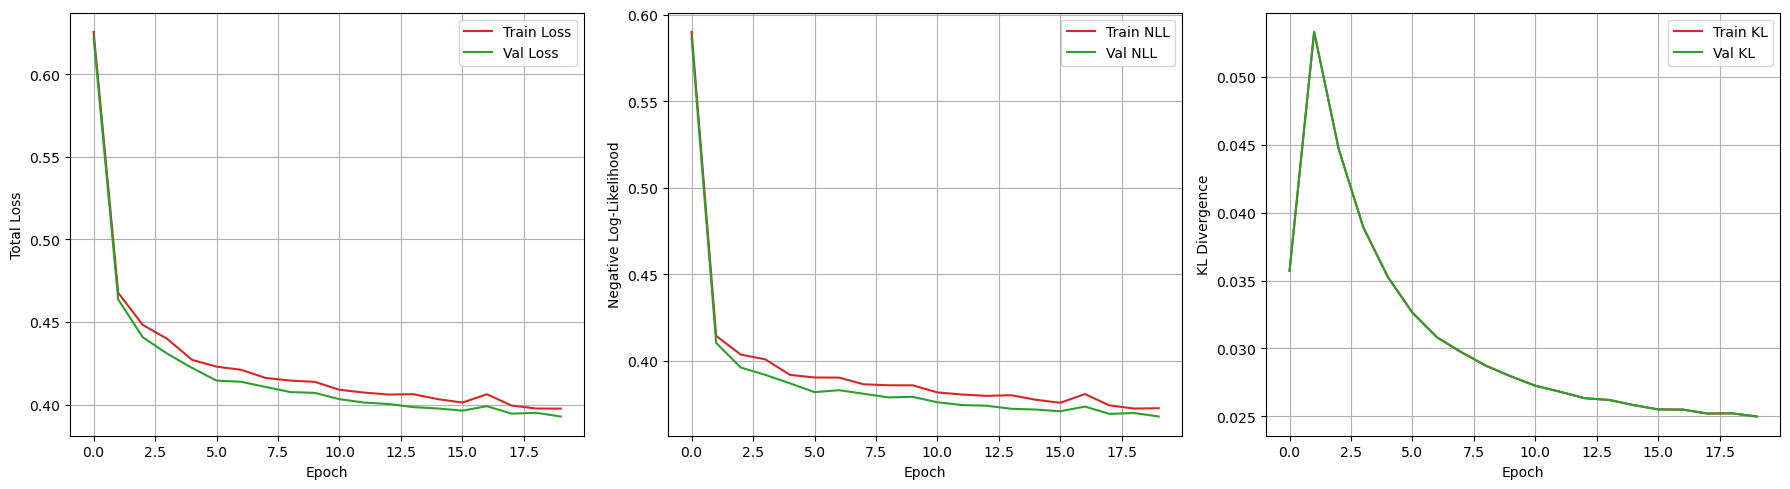

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Total loss
axs[0].plot(train_losses, label="Train Loss", color='tab:red')
axs[0].plot(val_losses, label="Val Loss", color='tab:green')
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Total Loss")
axs[0].legend()
axs[0].grid(True)

# Negative log-likelihood
axs[1].plot(train_nlls, label="Train NLL", color='tab:red')
axs[1].plot(val_nlls, label="Val NLL", color='tab:green')
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Negative Log-Likelihood")
axs[1].legend()
axs[1].grid(True)

# KL divergence
axs[2].plot(train_kls, label="Train KL", color='tab:red')
axs[2].plot(val_kls, label="Val KL", color='tab:green')
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("KL Divergence")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

## 9. Model Evaluation and Uncertainty Quantification

### Monte Carlo Sampling for Uncertainty

The key advantage of Bayesian neural networks is uncertainty quantification. We use Monte Carlo sampling to estimate predictive uncertainty.

In [26]:
def get_prediction(x, model, n_monte=30):
    """Get predictions with uncertainty using Monte Carlo sampling"""
    model.eval()
    predictions = []
    
    for i in range(n_monte):
        print(f"Monte Carlo sample {i+1}/{n_monte}")
        with torch.no_grad():
            pred = model(x)[:, 0].unsqueeze(1)
            predictions.append(pred)
        
    predictions = torch.stack(predictions)
    mean = torch.mean(predictions, dim=0)
    std = torch.std(predictions, dim=0)
    
    return mean, std

In [27]:
# Evaluate on test set with uncertainty quantification
samp_size = 5000  # Use subset for faster evaluation

# Get predictions with uncertainty
test_pred, test_std = get_prediction(z_test[:samp_size], model, n_monte=20)

# Calculate accuracy
test_pred_labels = torch.round(test_pred[:samp_size])
test_correct = (test_pred_labels == y_test[:samp_size]).sum().item()
test_accuracy = test_correct / len(test_pred_labels) * 100

print(f"Test Accuracy: {test_accuracy:.1f}%")

Monte Carlo sample 1/20
Monte Carlo sample 2/20
Monte Carlo sample 3/20
Monte Carlo sample 4/20
Monte Carlo sample 5/20
Monte Carlo sample 6/20
Monte Carlo sample 7/20
Monte Carlo sample 8/20
Monte Carlo sample 9/20
Monte Carlo sample 10/20
Monte Carlo sample 11/20
Monte Carlo sample 12/20
Monte Carlo sample 13/20
Monte Carlo sample 14/20
Monte Carlo sample 15/20
Monte Carlo sample 16/20
Monte Carlo sample 17/20
Monte Carlo sample 18/20
Monte Carlo sample 19/20
Monte Carlo sample 20/20
Test Accuracy: 84.6%


### ROC Curve Analysis

In [28]:
def closest_point(array, tpr_target=0.3):
    """Find closest point to target TPR"""
    dist = ((array - tpr_target)**2)
    return np.argmin(dist)

# Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_test[:samp_size].numpy(), test_pred.numpy())
auc_score = roc_auc_score(y_test[:samp_size].numpy(), test_pred.numpy())
background_rejection = 1 / fpr[closest_point(tpr, 0.3)]

print(f"AUC Score: {auc_score:.3f}")
print(f"Background Rejection at 30% Signal Efficiency: {background_rejection:.0f}")

AUC Score: 0.910
Background Rejection at 30% Signal Efficiency: 29


/var/folders/cz/0p99_3sd5vn72h_y01jd523c0000gn/T/ipykernel_50717/4244901429.py:16: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.3f}\n1/εₒₖ(0.3) = {background_rejection:.0f}', linewidth=2)
/var/folders/cz/0p99_3sd5vn72h_y01jd523c0000gn/T/ipykernel_50717/4244901429.py:17: RuntimeWarning: divide by zero encountered in divide
  ax[1].plot(rnd_class, 1/rnd_class, '--', label='Random Classifier', alpha=0.7)


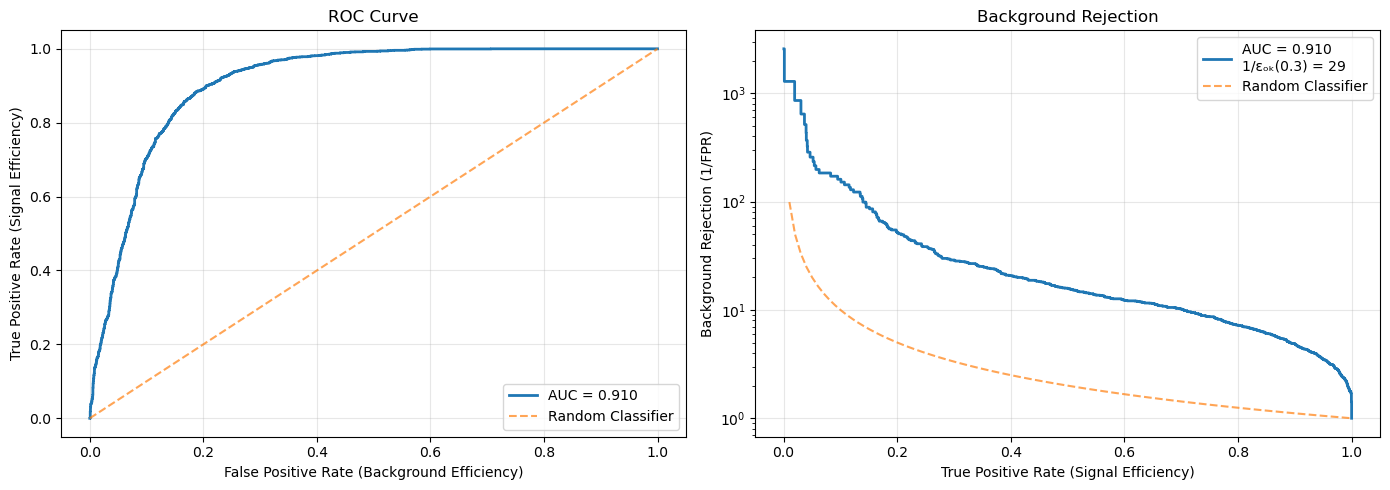

In [29]:
# Plot ROC curves
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

rnd_class = np.linspace(0, 1, 100)

# Standard ROC curve
ax[0].plot(fpr, tpr, label=f'AUC = {auc_score:.3f}', linewidth=2)
ax[0].plot(rnd_class, rnd_class, '--', label='Random Classifier', alpha=0.7)
ax[0].set_xlabel('False Positive Rate (Background Efficiency)')
ax[0].set_ylabel('True Positive Rate (Signal Efficiency)')
ax[0].legend()
ax[0].grid(True, alpha=0.3)
ax[0].set_title('ROC Curve')

# Background rejection plot
ax[1].plot(tpr, 1/fpr, label=f'AUC = {auc_score:.3f}\n1/εₒₖ(0.3) = {background_rejection:.0f}', linewidth=2)
ax[1].plot(rnd_class, 1/rnd_class, '--', label='Random Classifier', alpha=0.7)
ax[1].set_yscale('log')
ax[1].set_xlabel('True Positive Rate (Signal Efficiency)')
ax[1].set_ylabel('Background Rejection (1/FPR)')
ax[1].legend()
ax[1].grid(True, alpha=0.3)
ax[1].set_title('Background Rejection')

plt.tight_layout()
plt.show()

### Uncertainty Analysis

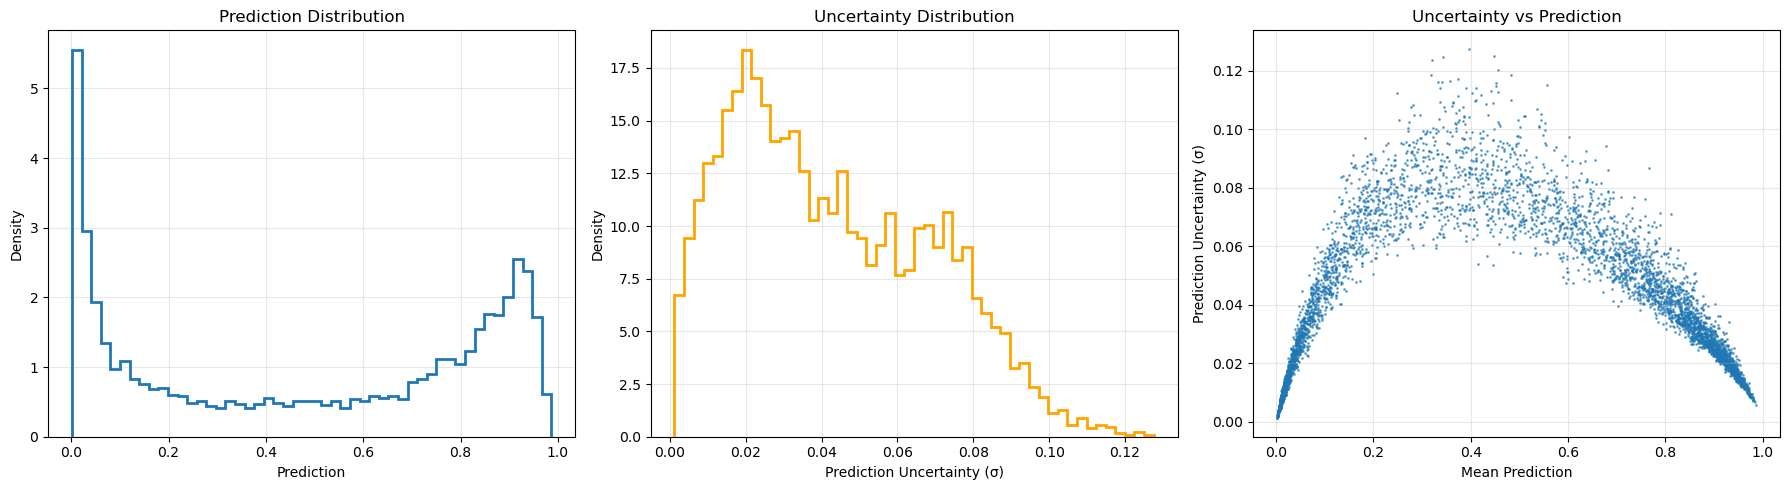


Uncertainty Statistics:
Mean uncertainty: 0.0426
Max uncertainty: 0.1275
Min uncertainty: 0.0012


In [30]:
# Analyze uncertainty patterns
test_std_np = test_std.reshape(-1).numpy()
test_pred_np = test_pred.reshape(-1).numpy()

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Prediction distribution
ax[0].hist(test_pred_np, bins=50, histtype="step", density=True, linewidth=2)
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Density')
ax[0].set_title('Prediction Distribution')
ax[0].grid(True, alpha=0.3)

# Uncertainty distribution
ax[1].hist(test_std_np, bins=50, histtype="step", density=True, linewidth=2, color='orange')
ax[1].set_xlabel('Prediction Uncertainty (σ)')
ax[1].set_ylabel('Density')
ax[1].set_title('Uncertainty Distribution')
ax[1].grid(True, alpha=0.3)

# Uncertainty vs prediction
scatter = ax[2].scatter(test_pred_np, test_std_np, alpha=0.6, s=1)
ax[2].set_xlabel('Mean Prediction')
ax[2].set_ylabel('Prediction Uncertainty (σ)')
ax[2].set_title('Uncertainty vs Prediction')
ax[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nUncertainty Statistics:")
print(f"Mean uncertainty: {test_std_np.mean():.4f}")
print(f"Max uncertainty: {test_std_np.max():.4f}")
print(f"Min uncertainty: {test_std_np.min():.4f}")

### Analysis of Results

The uncertainty analysis reveals important patterns:

1. **Prediction Distribution**: Shows clear separation between background (≈0) and signal (≈1) predictions.

2. **Uncertainty Distribution**: Most predictions have low uncertainty, with a tail of higher uncertainty cases.

3. **Uncertainty vs Prediction**: The characteristic "U" shape shows that:
   - Predictions near 0 or 1 have low uncertainty (model is confident)
   - Predictions near 0.5 have higher uncertainty (model is uncertain)
   - This is expected behavior for well-calibrated Bayesian classifiers

## 10. Summary and Conclusions

In this tutorial, you have learned:

1. **Bayesian Deep Learning Fundamentals**: How to treat neural network weights as probability distributions rather than fixed values.

2. **Implementation Details**: 
   - Variational Bayesian layers using the reparameterization trick
   - Bayesian convolutional layers for image processing
   - KL divergence regularization for proper weight distribution learning

3. **Training Bayesian Networks**: How to combine negative log-likelihood with KL divergence for the total loss function.

4. **Uncertainty Quantification**: Using Monte Carlo sampling to estimate predictive uncertainty, which is crucial for physics applications.

5. **Performance Evaluation**: Standard classification metrics (ROC curves, AUC) combined with uncertainty analysis.

### Key Advantages of Bayesian CNNs:
- **Uncertainty Quantification**: Know when the model is uncertain
- **Regularization**: KL divergence acts as automatic regularization
- **Robustness**: Better handling of out-of-distribution samples

### Applications in Particle Physics:
- **Systematic Uncertainty Estimation**: Model uncertainty contributes to systematic uncertainties
- **Data Quality Assessment**: High uncertainty regions may indicate problematic data
- **Decision Making**: Uncertainty-aware decisions in analysis pipelines

This framework can be extended to other particle physics applications such as particle identification, trigger systems, and analysis-specific classifiers where uncertainty quantification is valuable.